In [75]:
# Step 1: Libraries Import
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


In [23]:
df = pd.read_csv("C:\\Users\\kkais\\Downloads\\amazon_review.csv")  # path according to folder structure
print("Dataset Preview:")
print(df.head(2))

Dataset Preview:
       reviewerID        asin reviewerName helpful  \
0  A3SBTW3WS4IQSN  B007WTAJTO          NaN  [0, 0]   
1  A18K1ODH1I2MVB  B007WTAJTO         0mie  [0, 0]   

                                          reviewText  overall        summary  \
0                                         No issues.      4.0     Four Stars   
1  Purchased this for my device, it worked as adv...      5.0  MOAR SPACE!!!   

   unixReviewTime  reviewTime  day_diff  helpful_yes  total_vote  
0      1406073600  2014-07-23       138            0           0  
1      1382659200  2013-10-25       409            0           0  


In [24]:
df = df[['reviewText', 'overall']]
df

,reviewText,overall
0,No issues.,4.0
1,"Purchased this for my device, it worked as adv...",5.0
2,it works as expected. I should have sprung for...,4.0
3,This think has worked out great.Had a diff. br...,5.0
4,"Bought it with Retail Packaging, arrived legit...",5.0
...,...,...
4910,I bought this Sandisk 16GB Class 10 to use wit...,1.0
4911,Used this for extending the capabilities of my...,5.0
4912,Great card that is very fast and reliable. It ...,5.0
4913,Good amount of space for the stuff I want to d...,5.0


In [25]:
df.describe()

,overall
count,4915.000000
mean,4.587589
std,0.996845
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [26]:
# Check missing values
print(df.isnull().sum())

 


reviewText    1
overall       0
dtype: int64


In [39]:
# Fill missing reviewText with a placeholder
df.loc[:, 'reviewText'] = df['reviewText'].fillna('No review')



In [40]:
print(df.isnull().sum())

reviewText        0
overall           0
Sentiment         0
cleaned_review    0
dtype: int64


In [41]:
def map_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:  # 4 or 5
        return 'Positive'

df.loc[:, 'Sentiment'] = df['overall'].apply(map_sentiment)


In [42]:
print(df['Sentiment'].value_counts())


Sentiment
Positive    4449
Negative     324
Neutral      142
Name: count, dtype: int64


In [43]:
print(df[['reviewText', 'overall', 'Sentiment']].head())

                                          reviewText  overall Sentiment
0                                         No issues.      4.0  Positive
1  Purchased this for my device, it worked as adv...      5.0  Positive
2  it works as expected. I should have sprung for...      4.0  Positive
3  This think has worked out great.Had a diff. br...      5.0  Positive
4  Bought it with Retail Packaging, arrived legit...      5.0  Positive


In [44]:
# Step 3: Text Cleaning + Negation Handling
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r"not\s+(\w+)", r"not_\1", text)  # join negations like "not_good"
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)


In [45]:
df.loc[:, 'cleaned_review'] = df['reviewText'].apply(clean_text)
print("\nAfter Cleaning:")
print(df[['reviewText', 'cleaned_review', 'Sentiment']].head())



After Cleaning:
                                          reviewText  \
0                                         No issues.   
1  Purchased this for my device, it worked as adv...   
2  it works as expected. I should have sprung for...   
3  This think has worked out great.Had a diff. br...   
4  Bought it with Retail Packaging, arrived legit...   

                                      cleaned_review Sentiment  
0                                             issues  Positive  
1  purchased device worked advertised never much ...  Positive  
2  works expected sprung higher capacity think ma...  Positive  
3  think worked greathad diff bran gb card went s...  Positive  
4  bought retail packaging arrived legit orange e...  Positive  


In [48]:
# Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['Sentiment']

In [56]:
# Step 5: Balance Dataset with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("\nAfter SMOTE Balancing:")
print(y_res.value_counts())



After SMOTE Balancing:
Sentiment
Positive    4449
Neutral     4449
Negative    4449
Name: count, dtype: int64


In [57]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=43)


In [58]:
# Step 7: Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

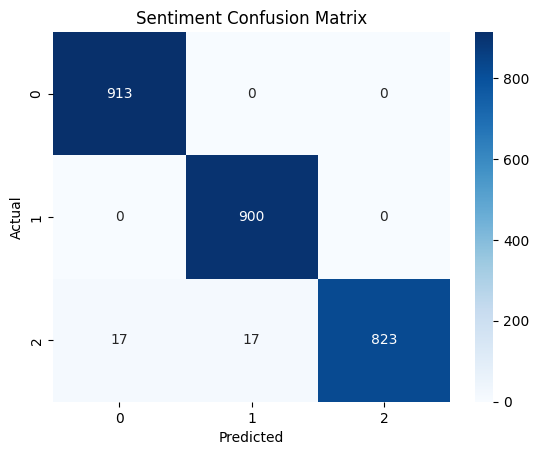

In [98]:
# step 7: Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Sentiment Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [59]:
# Step 8: Evaluation
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 98.72659176029963 %

Classification Report:
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       913
     Neutral       0.98      1.00      0.99       900
    Positive       1.00      0.96      0.98       857

    accuracy                           0.99      2670
   macro avg       0.99      0.99      0.99      2670
weighted avg       0.99      0.99      0.99      2670



In [60]:
# Step 9: Real-time Prediction Function
def predict_sentiment(review):
    cleaned = clean_text(review)
    vector = vectorizer.transform([cleaned])  # vectorizer is now fitted
    return model.predict(vector)[0]



In [96]:
 def predict_sentiment(review):
    score = vader.polarity_scores(review)['compound']
    # Lower threshold for neutral
    if score >= 0.25:
        return 'Positive'
    elif score <= -0.25:
        return 'Negative'
    else:
        return 'Neutral'


In [97]:
print("This product is bad! ->", predict_sentiment("This product is bad!"))
print("This product is not good! ->", predict_sentiment("This product is not good!"))
print("I love this item! ->", predict_sentiment("I love this item!"))
print("The quality is okay, not great ->", predict_sentiment("The quality is okay, not great"))
print("Worst product ever ->", predict_sentiment("Worst product ever"))


This product is bad! -> Negative
This product is not good! -> Negative
I love this item! -> Positive
The quality is okay, not great -> Negative
Worst product ever -> Negative
